STCDO Tranche Pricing
-------------------

The par spread $S$ of a CDS tranche is given by
$$S = \frac{\text{Protection Leg PV}}{\text{RPV01}},$$

where
$$\begin{aligned}
\text{RPV01} &= \sum_{i} \Delta_i Z(t_i) \frac{Q(t_{i-1},K_1,K_2), Q(t_i, K_1, K_2)}{2} \\
\text{Protection Leg PV} &= \int_{0}^{T} Z(t) (-dQ(t,K_1,K_2))
\end{aligned}$$

Here, 

* $K_1, K_2, T$ is the tranche starting level, final level, and maturity, respectively.
* $Z(t)$ is the discount factor curve.
* $Q(t,K_1,K_2)$ is the tranche survival curve: $Q(t,K_1,K_2)= 1 - \frac{f(t, K_2) - f(t, K_1)}{K_2 - K_1}$
* $t_i$ is the time of the $i^{th}$ premium payment. And $\Delta_i$ is the time-fraction of the $i^{th}$
  interval, using the Act365 DCF.
 
  
And $f(t,K) = E[ \min (L(t),K)]$ is model-dependent.

In [4]:
from datetime import timedelta
class Tranche(object):
    """Defines a generic CDO tranche class for pricing.
    
    Attributes:
        f (callable function): A function f(t,K) that takes in two floating point
            values and returns a float. Represents E[min(L(t)),K]. It is model-dependent.
        maturity (datetime.date): The maturity of the CDO. Should be given in "days" (no
            hours, minutes, seconds).
        K_1 (float): The starting value of the tranche. Must be between 0 and 1.
        K_2 (float): the ending value of the tranche. Must be between 0 and 1.
        remaining_payments (list): A list of datetime.date objects indicating the remaining
            premium payment dates in the tranche
        Z (callable function): A function Z(t) that outputs the discount factor Z(t) for a
            given time t. Input and output are both positive floats.
        today (datetime.date): The present date.
    """
    def __init__(self, f, maturity, K1, K2, remaining_payments, Z, today):
        self.f = f
        self.maturity = maturity
        self.K1 = K1
        self.K2 = K2
        self.remaining_payments = remaining_payments
        self.Z = Z
        self.today = today
    def qtranche(self, t):
        """Calculates the tranche survival curve at time t.
        
        Args:
            t (float): The time at which the tranche survival curve is calculated.
        Returns:
            float: The value of the tranche survival curve.
        """
        if t == self.today:
            return 1
        x = 1 - (self.f(t, self.K2) - self.f(t, self.K1)) / (self.K2 - self.K1)
        return x
    def rpv01(self):
        # Returns the tranche RPV01 (Notional ==1)
        remaining_payments = self.remaining_payments
        delta = (remaining_payments[0] - self.today).days / 365
        x = 1
        y = self.qtranche(remaining_payments[0])
        total = delta * self.Z(remaining_payments[0]) * (x + y) / 2
        for i in range(1, len(remaining_payments)):
            x = self.qtranche(remaining_payments[i - 1])
            y = self.qtranche(remaining_payments[i])
            delta = (remaining_payments[i] - remaining_payments[i - 1]).days / 365
            total = total + delta * self.Z(remaining_payments[i]) * (x + y) / 2
        return total
    def protectionLegPV(self, N = 150):
        # Returns the PV of the tranche protection leg (Notional == 1)
        # Uses N subintervals of integration. 
        date_range = [today + (self.maturity - today) / N * n for n in range(N)]
        total = 0
        Q = [self.qtranche(date) for date in date_range]
        for i in range(1,len(date_range)):
            dQ = Q[i] - Q[i - 1]
            total = total + -1 * Z(date_range[i]) * dQ
        return total
    def parSpread(self, N=150):
        # Returns the fair par spread for the tranche 
        return self.protectionLegPV(N) / self.rpv01()

Large Homogenous Portfolio (LHP) Model
--------------------------------------

The LHP tranche pricing model is given by the following equations:
$$\begin{aligned}
E[\min (L(T), K)] &= (1-R) \Phi_{2}(C(T), -A(K), - \beta) + K \Phi(A(K)) \\
A(K) &= \frac{1}{\beta} \left( C(T) - \sqrt{1 - \beta^{2}} \Phi^{-1} \left( \frac{K}{1-R} \right) \right) \\
C(T) &= \Phi^{-1} (1 - Q(T))
\end{aligned}$$

Here:
* $\Phi_{2}$ is the cdf of the bivariate normal distribution. The third perameter being correlation.
* $\beta^{2}$ the correlation
* $R$ is the recovery rate.
* $Q(T)$ is the survival curve

In [8]:
from scipy.stats import norm, mvn
from numpy       import sqrt
def LHP(T, K, beta, Q, R):
    """ Calculates E[min(L(T), K)] in the LHP model:
    
    Args:
        T (datetime.date): Should be given in "days" (no hours, minutes, etc.)
        K (float): Its value should be between 0 and 1.
        beta (float): Its value should be between 0 and 1.
        Q (callable function): A function Q that takes in a dateime.date and outputs
            a float from 0 to 1. It is assumed that Q(0) = 1 and Q is decreasing. Represents
            survival curve.
        R (float): Recovery rate. Usually between 0 and 1.
    Returns: 
        float: The value of E[min(L(T),K)] in the LHP model.
    """
    C = norm.ppf(1 - Q(T))
    A = (1 / beta) * (C - sqrt(1 - beta * beta) * norm.ppf(K / (1 - R)))
    return (1 - R) * mvn.mvndst(upper = [C, -1 * A],
                                lower = [0,0],
                                infin = [0,0],
                                correl =  -1 * beta)[1] + K * norm.cdf(A)

LHP Example
-----------

We consider an LHP model with

* $\lambda$ = 180 bps.
* $r$ = 3%
* $\beta^{2}$ = 20% ($\beta$ =0.45)
* $R$ = 40%
* Today being Jan 1, 2012.
* Premium payments being made every 30 days.
* The maturity date ranging from 1 through 10 years.

We price the (5%,10%)-level tranche.

In [9]:
from datetime import date
from numpy    import exp
today = date(2012, 1, 1)
hazard_rate = 0.0180
interest_rate = 0.03
R = 0.4
# define Q(t) & Z(t)
def Q(t):
    return exp(-1 * hazard_rate * (t - today).days / 365)
def Z(t):
    return exp(-1 * interest_rate * (t - today).days / 365)

# define f(t,K) = E[min(L(t), K)]

f = lambda t, K: LHP(T = t, K = K, beta = 0.45, Q = Q, R = R)

# define array of tranches
maturities = [today + timedelta(days = 365) * n for n in range(1,11)]
payments = [[today + n * timedelta(days=30) for n in range(int((maturity - today) 
                                                               / timedelta(days=30)) + 1)]
            for maturity in maturities]

spreads = [10000 * Tranche(f = f,
                     K1 = 0.05,
                     K2 = 0.10,
                     maturity = maturity,
                     remaining_payments = payment,
                     Z = Z,
                     today = today
                    ).parSpread() for maturity, payment in zip(maturities, payments)]

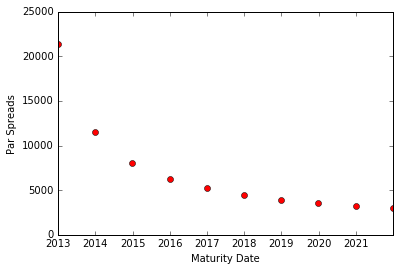

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
x = maturities
y = spreads
plt.xlabel("Maturity Date")
plt.ylabel("Par Spreads")
plt.plot(x,y, 'ro')